## Abdul Rahman - BSCS18022
## Assignment 2
### Hough Transform


In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import sys

uint8 (540, 960, 3)


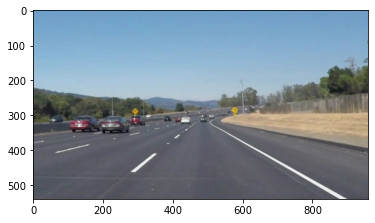

In [2]:
im1_str = 'test/test3.jpg'
img1 = plt.imread(im1_str)

print(img1.dtype, img1.shape)
plt.imshow(img1)

## for different mask

In [3]:


def bin_it(image, threshold):
    """
    converts a single channeled image to a binary image,
    using upper and lower threshold
    """
    assert len(image.shape) == 2, 'Image received has more than one channel'
    
    output_bin = np.zeros_like(image)
    output_bin[(image >= threshold[0]) & (image <= threshold[1])]=1
    return output_bin

def threshold_colours(image):
    """
    Return binary image from thresholding colour channels
    img: RGB image
    """
    # convert image to hls colour space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    
    # binary threshold values
    bin_thresh = [20, 255]
    
    # rgb thresholding for yellow
    lower = np.array([225,180,0],dtype = "uint8")
    upper = np.array([255, 255, 170],dtype = "uint8")
    mask = cv2.inRange(image, lower, upper)
    rgb_y = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8)
    rgb_y = cv2.cvtColor(rgb_y, cv2.COLOR_RGB2GRAY)
    rgb_y = bin_it(rgb_y, bin_thresh)
    
    
    # rgb thresholding for white (best)
    lower = np.array([100,100,200],dtype = "uint8")
    upper = np.array([255, 255, 255],dtype = "uint8")
    mask = cv2.inRange(image, lower, upper)
    rgb_w = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8)
    rgb_w = cv2.cvtColor(rgb_w, cv2.COLOR_RGB2GRAY)
    rgb_w = bin_it(rgb_w, bin_thresh)
    
    
    # hls thresholding for yellow
    lower = np.array([20,120,80],dtype = "uint8")
    upper = np.array([45, 200, 255],dtype = "uint8")
    mask = cv2.inRange(hls, lower, upper)
    hls_y = cv2.bitwise_and(image, image, mask = mask).astype(np.uint8)
    hls_y = cv2.cvtColor(hls_y, cv2.COLOR_HLS2RGB)
    hls_y = cv2.cvtColor(hls_y, cv2.COLOR_RGB2GRAY)
    hls_y = bin_it(hls_y, bin_thresh)
    
    im_bin = np.zeros_like(hls_y)
    im_bin [(rgb_y == 1)|(rgb_w==1)|(hls_y==1)]= 1
    
    return im_bin


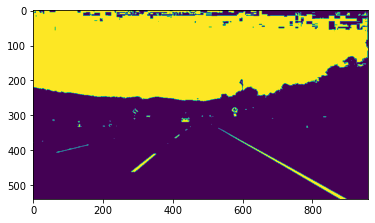

In [4]:
output1 = threshold_colours(img1)

plt.imshow(output1)

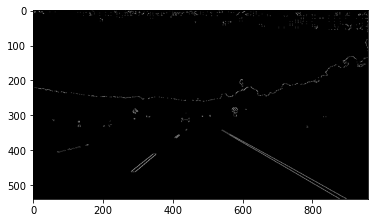

In [5]:
edges1 = cv2.Canny(output1,5,5)

plt.imshow(edges1, cmap='gray')

In [7]:
def ROI(image):
    
    ratio_irrelevent = 1.7
    percentage_of_opp_side = 10       
    img = image.copy()
    
    xch = round(len(img[0])/percentage_of_opp_side)
    
    decrement = (len(img[0])/2 - xch)/ (len(img) - len(img)/ratio_irrelevent)
    
    for i in range(0, len(img)):
        
        if(i < round(len(img)/ratio_irrelevent)):
            for j in range(0, len(img[i])):
                img[i][j] = 0
        else:
            if(xch < round(len(img[i])/2) - round(decrement+1)):
                xch = xch + decrement
                
            lowerLimit = round( len(img[i])/2 - xch)
            upperLimit = round( len(img[i])/2 + xch)
           
            for j in range(0, lowerLimit):
                    img[i][j] = 0
            for j in range(upperLimit, len(img[i])):
                    img[i][j] = 0
    return img
        

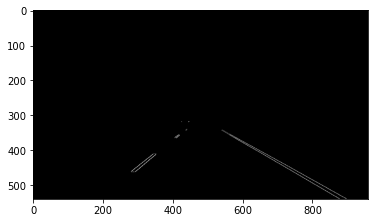

In [8]:
ROI_1 = ROI(edges1)

plt.imshow(ROI_1, cmap='gray')

In [9]:
def HoughTransform(cannyedge, threshold_count, local_maxima_range):
    if (local_maxima_range % 2) == 0:
        print("Enter an odd size")
        return None
    
    height = len(cannyedge)
    width = len(cannyedge[0])
    diagonalsize = round(math.sqrt(height**2 + width**2))
#     print("Diagonal size: ")
#     print(diagonalsize)
    
    half_height = round(height/2)
    half_width = round(width/2)
    dsize = (diagonalsize*2)+1
    maxangle = 360
    
    accumulator = np.zeros((maxangle, dsize))
    waveimg = np.zeros((dsize, maxangle))
    lines = []
    points = []

    # Accumulating Peaks
    for i in range(height):
        for j in range(width):
            if cannyedge[i][j] == 255:
                for theta in range(len(accumulator)):
                    # j is x
                    # i is y                
                    currentrho = (j*math.cos(theta)) + (i*math.sin(theta))
#                     print(currentrho)
                    accumulator[round(theta), round(currentrho+diagonalsize+1)] += 1
                    waveimg[round(currentrho+diagonalsize+1), round(theta)] = 255
                
     
    half = int(local_maxima_range/2)
    suppressed = False
    
    # Finding Local Extrema
    
    for i in range(len(accumulator)):
        for j in range(len(accumulator[0])):            
            if accumulator[i][j] > 0:
                suppressed = False
                for k in range(-half, half):
                    for l in range(-half, half):
                        if (i+k) < maxangle and (i+k) >= 0 and (j+l) >= 0 and (j+l) < dsize:
                            if accumulator[i+k][j+l] > accumulator[i][j]:
                                accumulator[i][j] = 0
                                suppressed = True
                        if suppressed is True:
                            break
                    if suppressed is True:
                            break     
                            
                    
    for theta in range(len(accumulator)):
        for rho in range(len(accumulator[0])):
            if accumulator[theta][rho] >= threshold_count:
#                 print(rho-diagonalsize-1)
                a = math.cos(theta)
                b = math.sin(theta)
                rho -= (diagonalsize-1)
#                 if rho > (diagonalsize):
#                     rho = rho/2

                x0 = (a * (rho+1))
                y0 = (b * (rho+1))
                
                
                
                x1 = round(x0 + 1000 * (-b))
                y1 = round(y0 + 1000 * (a))
                x2 = round(x0 - 1000 * (-b))
                y2 = round(y0 - 1000 * (a))
                m = (y2-y1)/(x2-x1)
                
                
                c = y0-m*x0
                y1 = len(cannyedge)
                x1 = round((y1-c)/m)
                y2 = round(len(cannyedge)/2+100)
                x2 = round((y2-c)/m)
                
                print("RHO, ACCUM, Theta, slope")
                print(rho)
                print(accumulator[theta][rho])
                print(theta)
                print(m)
                print([[x0, y0], [x1, y1], [x2, y2]])
                
                if abs(x1) > diagonalsize or abs(y1) > diagonalsize or abs(y2) > diagonalsize or abs(x2) > diagonalsize:
                    print(f"Skipped: x1, y1, x2, y2: {[[x1, y1], [x2, y2]]}")
                
                lines.append([x1, y1, x2, y2, x0, y0])
                
    return lines, waveimg

In [10]:

lines, waveimg = HoughTransform(ROI_1, threshold_count= 50, local_maxima_range = 9)
if lines is None:
    sys.exit()

RHO, ACCUM, Theta, slope
-539
0.0
4
-0.8638466622604097
[[351.66026802462324, 407.1597424756654], [198, 540], [395, 370]]
RHO, ACCUM, Theta, slope
543
0.0
26
-0.8485245901639344
[[351.92411134678036, 414.83179706090385], [204, 540], [405, 370]]
RHO, ACCUM, Theta, slope
-540
0.0
48
-0.8333333333333334
[[345.03779897389865, 414.0892624534564], [194, 540], [398, 370]]
RHO, ACCUM, Theta, slope
-533
0.0
48
-0.8327911515940143
[[340.55678859761423, 408.71147982419075], [183, 540], [387, 370]]
RHO, ACCUM, Theta, slope
537
0.0
70
-0.8184754521963824
[[340.7257312604293, 416.3531866781443], [190, 540], [397, 370]]
RHO, ACCUM, Theta, slope
544
0.0
70
-0.8184754521963824
[[345.1589656820334, 421.77042144904954], [201, 540], [408, 370]]
RHO, ACCUM, Theta, slope
-540
0.0
92
-0.8037203335471456
[[337.65355742367274, 420.13221152291874], [189, 540], [400, 370]]
RHO, ACCUM, Theta, slope
-533
0.0
92
-0.8037203335471456
[[333.26844628830037, 414.6759490356081], [177, 540], [389, 370]]
RHO, ACCUM, Theta,

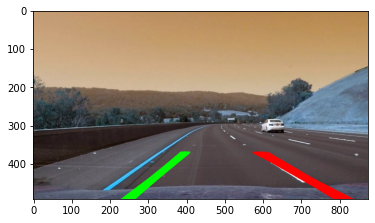

In [11]:
imgn = cv2.imread('test/test1.jpg')
leftpointsx = []
leftpointsy = []
rightpointsx = []
rightpointsy = []

for line in lines:
    x1, y1, x2, y2, x0, y0 = line
    m = (y2-y1)/(x2-x1)
    if m <= 1 and m >= 0.2:
#         rightpoints.append([x0, y0])
        rightpointsx.append(x1)
        rightpointsy.append(y1)
        rightpointsx.append(x2)
        rightpointsy.append(y2)
        cv2.line(imgn, (x1, y1), (x2, y2), (255, 0, 0), 3)
        
    elif m >= -1 and m <= -0.2:    
#         leftpoints.append([x0, y0])
        leftpointsx.append(x1)
        leftpointsy.append(y1)
        leftpointsx.append(x2)
        leftpointsy.append(y2)
        cv2.line(imgn, (x1, y1), (x2, y2), (0, 255, 0), 3)
        
plt.imshow(imgn)

In [12]:
def squaresum(lst):
    summ = 0
    for i in lst:
        summ += i*i
    return summ

def mean(lst):
    if len(lst) ==0:
        sys.exit()
    return sum(lst)/len(lst)

def linearregression(xvalues, yvalues, count):
    xavg = mean(xvalues)
    yavg = mean(yvalues)
    xysum = sum([a * b for a, b in zip(xvalues, yvalues)])
    slope = (xysum - count*xavg*yavg)/(squaresum(xvalues) - count*(xavg**2))
    intercept = yavg-slope*xavg
    return slope, intercept

-0.8089545533779552
692.5148351185775
[380, 385, 0, 693]
0.556125977204231
41.902672557982214
[580, 364, 960, 576]


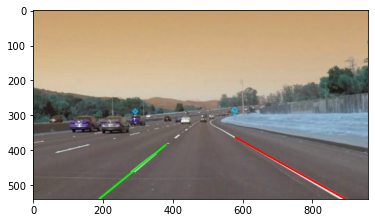

In [13]:
imgn = cv2.imread(im1_str)
black = np.zeros((len(imgn), len(imgn[0])))
m, c= linearregression(leftpointsx, leftpointsy, len(leftpointsy))
print(m)
print(c)
x1 = round(len(imgn[0])/2 - 100)
y1 = round(x1*m+c)
x2 = 0
y2 = round(c)
print(f"{[x1, y1, x2, y2]}")
cv2.line(imgn, (x2, y2), (x1, y1), (0, 255, 0), 3)
cv2.line(black, (x2, y2), (x1, y1), (255, 0, 0), 3)

m, c = linearregression(rightpointsx, rightpointsy, len(rightpointsy))
print(m)
print(c)
x1 = round(len(imgn[0])/2 + 100)
y1 = round(x1*m+c)
x2 = round(len(imgn[0]))
y2 = round(x2*m+c)
print(f"{[x1, y1, x2, y2]}")
cv2.line(imgn, (x2, y2), (x1, y1), (255, 0, 0), 3)
cv2.line(black, (x2, y2), (x1, y1), (255, 0, 0), 3)


plt.imshow(imgn, cmap='gray')